In [2]:
import pandas as pd
import numpy as np

# Step 1: Load the Dataset
file_name = 'your_dataset.csv'  # Replace with your dataset file name
data = pd.read_csv("internet_usage.csv")

# Step 2: Display Dataset Information
print("Preview of the dataset:")
print(data.head())

print("\nBasic information about the dataset:")
print(data.info())

print("\nSummary statistics for numeric columns:")
print(data.describe())

# Step 3: Check for Missing Data
print("\nCount of missing values in each column:")
print(data.isnull().sum())

# Step 4: Handle Missing Data
# Method 1: Fill missing data with 0 for numeric columns (or any other simple approach if needed)
data_filled_0 = data.fillna(0)

# Method 2: Ensure all year columns are numeric
years = [str(year) for year in range(2000, 2024)]
for year in years:
    data[year] = pd.to_numeric(data[year], errors='coerce')  # Convert to numeric, set errors to NaN

# Method 3: Use linear interpolation to fill missing data for numeric columns
data_filled_linear = data.copy()
data_filled_linear[years] = data_filled_linear[years].interpolate(method='linear', axis=0)

# Method 4: Use CAGR (Compound Annual Growth Rate) for large gaps (you can adjust this step if needed)
def calculate_cagr(df, start_year, end_year, start_column, end_column):
    start_value = df[start_column]
    end_value = df[end_column]
    years = end_year - start_year
    if years > 0:
        cagr = (end_value / start_value) ** (1 / years) - 1
        return cagr
    return np.nan

def fill_missing_with_cagr(df):
    df_filled_cagr = df.copy()
    # Apply CAGR filling for each missing data point
    for column in df_filled_cagr.columns[2:]:  # Skip 'Country Name' and 'Country Code' columns
        for i, row in df_filled_cagr.iterrows():
            if pd.isna(row[column]):
                # Calculate CAGR using data from available years (e.g., between 2000 and 2023)
                start_value = row['2000']  # Assuming 2000 is available
                end_value = row['2023']  # Assuming 2023 is available
                cagr = calculate_cagr(df_filled_cagr, 2000, 2023, '2000', '2023')
                df_filled_cagr.at[i, column] = start_value * (1 + cagr) ** (int(column) - 2000)  # Fill with projected CAGR
    return df_filled_cagr

# Choose the method you want to use to fill missing data:
data_filled = data_filled_linear  # Or use data_filled_0 or data_filled_cagr

# Step 5: Validate 'Country Name' Column
if 'Country Name' in data_filled.columns:
    print("\nUnique Country Names:")
    print(data_filled['Country Name'].unique())
else:
    print("\nError: 'Country Name' column is missing!")

# Step 6: Calculate Growth Rates (Ensure Yearly Columns Are Numeric)
if set(years).issubset(data_filled.columns):
    # Convert yearly columns to numeric (in case they are still object type)
    for year in years:
        data_filled[year] = pd.to_numeric(data_filled[year], errors='coerce')

    # Calculate Growth Rate (handle division by zero and NaN)
    data_filled['Growth Rate'] = (
        (data_filled['2023'] - data_filled['2000']) / data_filled['2000']
    ) * 100  # Percentage growth rate

    # Handle infinite or NaN growth rates
    data_filled['Growth Rate'] = data_filled['Growth Rate'].replace([np.inf, -np.inf], np.nan)
    data_filled['Growth Rate'] = data_filled['Growth Rate'].fillna(0)

    print("\nGrowth Rate calculated and added as a new column.")
else:
    print("\nError: Required yearly columns for calculating Growth Rate are missing.")

# Step 7: Validate Data Types
print("\nData types after cleaning:")
print(data_filled.dtypes)

# Convert numeric columns to float if they are not already
for column in years + ['Growth Rate']:
    if column in data_filled.columns and data_filled[column].dtype == object:
        try:
            data_filled[column] = data_filled[column].astype(float)
        except ValueError:
            print(f"Warning: Column {column} could not be converted to numeric.")

# Step 8: Summary of Growth Rates
if 'Growth Rate' in data_filled.columns:
    print("\nGrowth Rate Summary Statistics:")
    print(data_filled['Growth Rate'].describe())
else:
    print("\nGrowth Rate column is missing!")

# Step 9: Save the Cleaned Dataset
output_file = 'cleaned_dataset.csv'
data_filled.to_csv(output_file, index=False)
print(f"\nCleaned dataset saved as '{output_file}'.")


Preview of the dataset:
     Country Name Country Code      2000        2001       2002       2003  \
0     Afghanistan          AFG        ..  0.00472257  0.0045614  0.0878913   
1         Albania          ALB  0.114097    0.325798   0.390081     0.9719   
2         Algeria          DZA  0.491706    0.646114    1.59164    2.19536   
3  American Samoa          ASM        ..          ..         ..         ..   
4         Andorra          AND   10.5388          ..    11.2605    13.5464   

       2004     2005     2006     2007  ...  2014  2015     2016     2017  \
0  0.105809  1.22415  2.10712      1.9  ...     7  8.26       11     13.5   
1   2.42039  6.04389  9.60999  15.0361  ...  54.3  56.9     59.6     62.4   
2   4.63448  5.84394  7.37598  9.45119  ...  29.5  38.2  42.9455  47.6911   
3        ..       ..       ..       ..  ...    ..    ..       ..       ..   
4    26.838  37.6058  48.9368    70.87  ...  86.1  87.9     89.7  91.5675   

      2018     2019     2020     2021     20

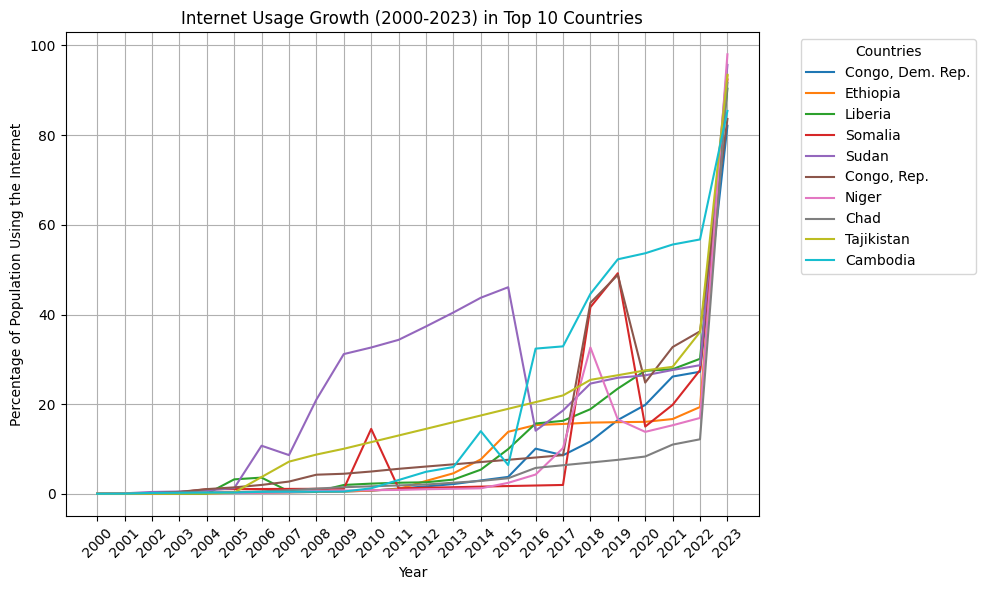

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'data_filled' is the cleaned dataset
years = [str(year) for year in range(2000, 2024)]
data_filled.set_index('Country Name', inplace=True)

# Select countries with notable growth (e.g., top 10 countries with the largest growth in internet usage)
top_growth_countries = data_filled.sort_values(by='Growth Rate', ascending=False).head(10)

# Plot internet usage over time for top growth countries
plt.figure(figsize=(10, 6))

for country in top_growth_countries.index:
    plt.plot(years, top_growth_countries.loc[country, years], label=country)

plt.title('Internet Usage Growth (2000-2023) in Top 10 Countries')
plt.xlabel('Year')
plt.ylabel('Percentage of Population Using the Internet')
plt.legend(title='Countries', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Rotate the x-axis labels to avoid overlapping
plt.xticks(rotation=45)  # Rotating the labels by 45 degrees

# Save or display the plot
plt.tight_layout()
plt.savefig('internet_usage_growth.png')
plt.show()
